In [73]:
import cv2
import time
import scipy.io as sio
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

### Detect the Face using Haar Cascade Classifier

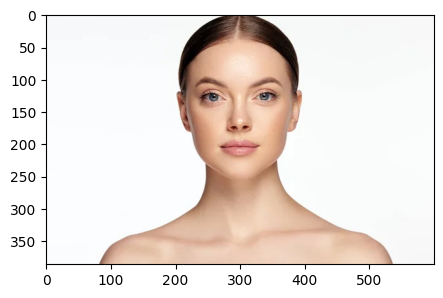

In [74]:
face = cv2.imread("../images/face.jpg")
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 5))
plt.imshow(face)
plt.show()

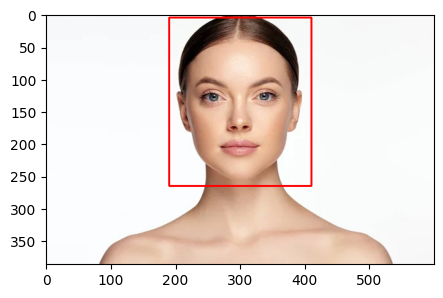

In [75]:
detector = cv2.CascadeClassifier("../data/haarcascade_frontalface_default.xml")
results = detector.detectMultiScale(face, 1.3, 5)
face_copy = np.copy(face)
for (x, y, w, h) in results:
    cv2.rectangle(face_copy, (x-10, y-40), (x+w+10, y+h+20), (255, 0, 0), 2)

plt.figure(figsize=(5, 5))
plt.imshow(face_copy)
plt.show()



### Segment the face


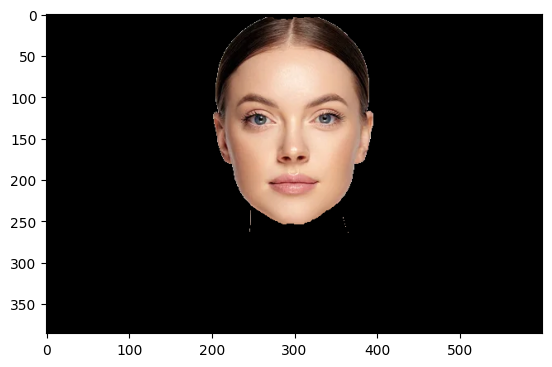

Total time taken for segmentation: 0.82 seconds


In [76]:
# segment out the face using grabcut
st = time.time()
bgModel = np.zeros((1, 65), np.float64)
fgModel = np.zeros((1, 65), np.float64)

mask = np.zeros(face.shape[:2], np.uint8)

rect = (results[0][0]-10, results[0][1]-40, results[0][2]+10, results[0][3]+60)
face_copy = np.copy(face)
cv2.grabCut(face_copy, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
face_copy = face_copy*mask2[:, :, np.newaxis]

plt.imshow(face_copy)
plt.show()

et = time.time()
print(f"Total time taken for segmentation: {et-st:.2f} seconds")

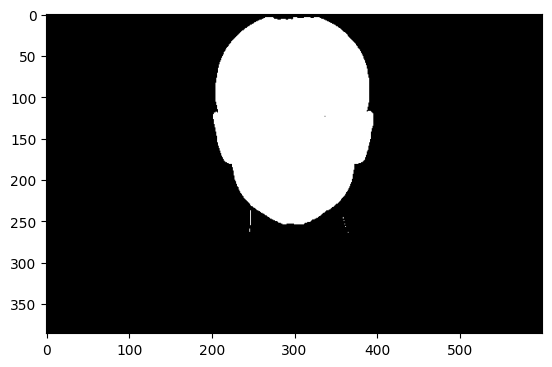

In [77]:
# display face mask
plt.imshow(mask2, cmap='gray')
plt.show()

#### Smoothen the mask using Gaussian Blurring

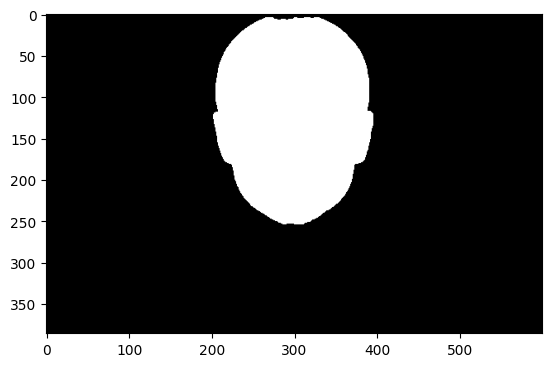

In [78]:
# smoothen the mask with a gaussian filter
mask2 = cv2.GaussianBlur(mask2, (5, 5), 0)
plt.imshow(mask2, cmap='gray')
plt.show()

### Face Landmarks


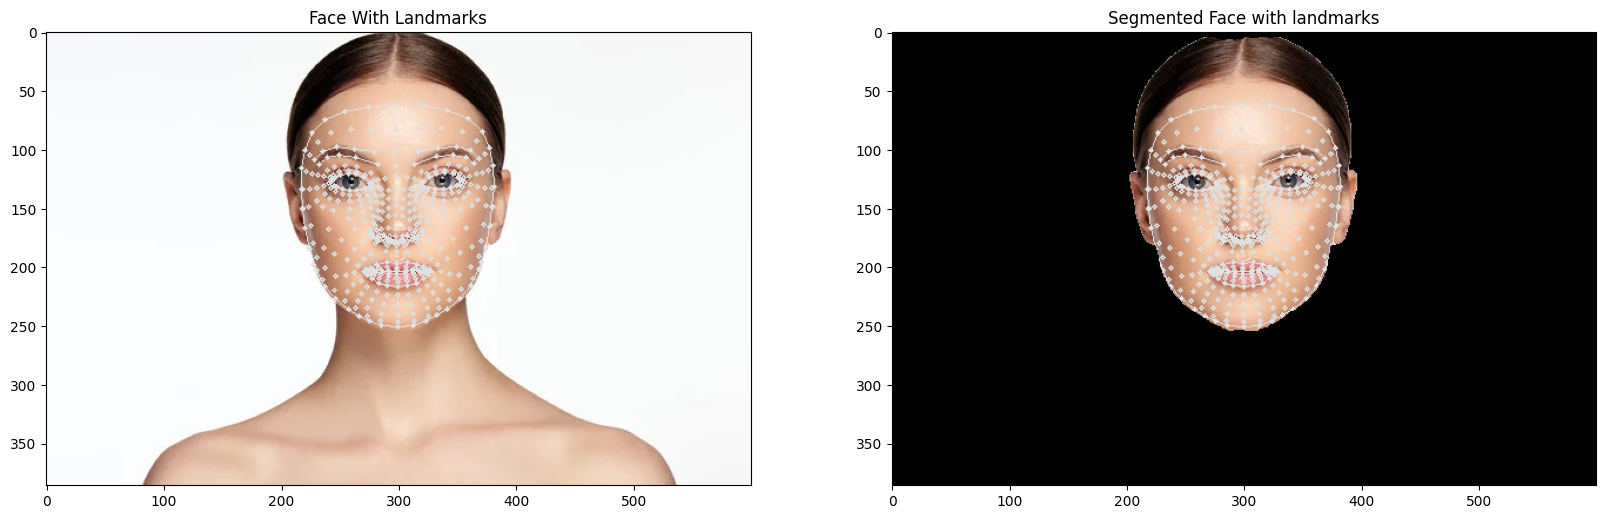

In [79]:
mpDraw = mp.solutions.drawing_utils
mpFaceMesh = mp.solutions.face_mesh
face_mesh = mpFaceMesh.FaceMesh(max_num_faces=1)
drawSpec = mpDraw.DrawingSpec(thickness=1, circle_radius=1)

face_copy = np.copy(face)
landmarks = face_mesh.process(face_copy)
if landmarks.multi_face_landmarks:
    for face_landmarks in landmarks.multi_face_landmarks:
        mpDraw.draw_landmarks(face_copy, face_landmarks, mpFaceMesh.FACEMESH_CONTOURS, drawSpec, drawSpec)


segmented_face = np.multiply(face_copy, mask2[:, :, np.newaxis])
plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.title("Face With Landmarks")
plt.imshow(face_copy)
plt.subplot(1,2,2)
plt.title("Segmented Face with landmarks")
plt.imshow(segmented_face)
plt.show()

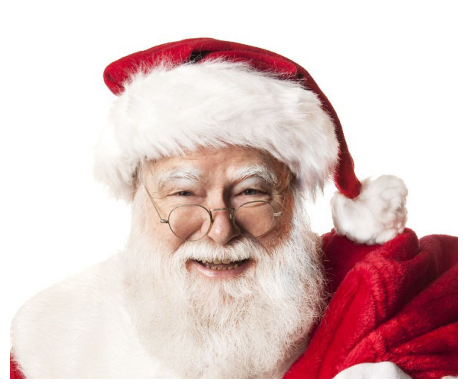

In [80]:
mat = sio.loadmat('../mask_files/santa.mat')

santa = mat['Imask']
face_map = mat['Imask_map']
face_map[face_map<127] = 0
face_map[face_map>=127] = 255
hat_map = mat['Imask_map_hat']
hat_map[hat_map<127] = 0
hat_map[hat_map>=127] = 255

x_coords, y_coords = mat['landmark_points_array_mask'][0][0]

santa_landmarks = []
for i in range(len(x_coords)):
    santa_landmarks.append([x_coords[i], y_coords[i]])

plt.imshow(santa)
plt.axis('off')
plt.show()

In [81]:
# for i in mat:
#     if i.startswith('Imask'):
#         continue
#     print(i, mat[i])

(['__header__', '__version__', '__globals__', 'Imask', 'Imask_map', 'Imask_map_hat', 'TempK', 'a', 'add_hat', 'add_vignetting', 'amp', 'avoid_artifacts', 'change_color_temp', 'effect', 'effect_img', 'face_mask', 'filt', 'gradient_blur', 'hat_c', 'hat_line', 'hat_w', 'landmark_points_array_mask', 'makeEyeHoles'])

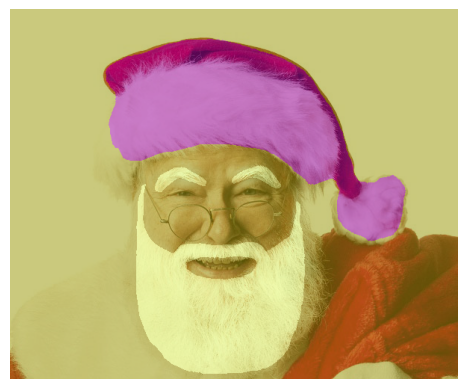

In [82]:
map1 = np.array(cv2.normalize(face_map, None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
map1 = cv2.applyColorMap(map1, cv2.COLORMAP_MAGMA)

map2 = np.array(cv2.normalize(hat_map, None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
map2 = cv2.applyColorMap(map2, cv2.COLORMAP_COOL)

blended = cv2.addWeighted(santa, 0.7, map1, 0.3, 0)
blended = cv2.addWeighted(blended, 0.7, map2, 0.3, 0)

plt.imshow(blended)
plt.axis('off')
plt.show()

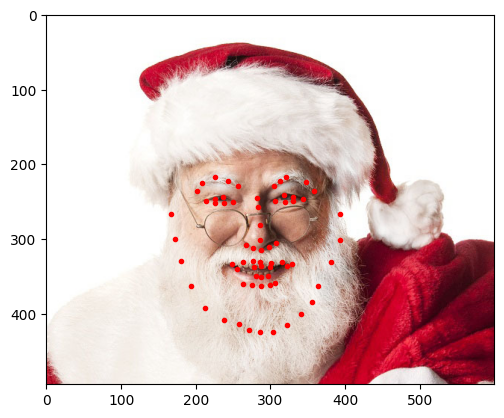

In [83]:
plt.imshow(mat['Imask'])
plt.scatter(x_coords, y_coords, color='red', marker='.')
plt.show()

In [84]:
# # Calculate warpaffine transformation matrix between the face landmarks and santa landmarks

# transform_matrix = cv2.estimateAffinePartial2D(
#     np.array(santa_landmarks), 
#     np.array(landmarks.multi_face_landmarks.landmark).astype(np.float32)
# )